In [1]:
import os,glob
import scipy
import torch
import numpy as np
import librosa as rs
import soundfile as sf
from scipy import io
import random

import matplotlib.pyplot as plt   
import IPython.display as ipd

/home/kbh/.conda/envs/dnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PAth

In [2]:
root_rir    = "/home/data2/kbh/MIDR___Multi-Channel_Impulse_Response_Database/"
root_speech = "/home/nas/DB/CHiME4/data/audio/16kHz/isolated/tr05_org/"
root_noise  = "/home/nas/DB/DEMAND/dataset/"

list up

In [62]:
list_room_train = []
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_3-3-3-8-3-3-3")
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_3-3-3-8-3-3-3")
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.610s)_3-3-3-8-3-3-3")
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_8-8-8-8-8-8-8")
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_8-8-8-8-8-8-8")
list_room_train.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.610s)_8-8-8-8-8-8-8")

list_rir_test = []
list_rir_test.append(glob.glob(os.path.join(root_rir,"Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_4-4-4-8-4-4-4","*.mat")))
list_rir_test.append(glob.glob(os.path.join(root_rir,"Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_4-4-4-8-4-4-4","*.mat")))
list_rir_test.append(glob.glob(os.path.join(root_rir,"Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.610s)_4-4-4-8-4-4-4","*.mat")))

print("RIR train : {} | RIR test : {}".format(len(list_rir_train),len(list_rir_test)))

list_speech = glob.glob(os.path.join(root_speech,"*.wav"))
random.shuffle(list_speech)
idx_split = int(len(list_speech)*0.25)
list_speech_train = list_speech[idx_split:]
list_speech_test = list_speech[:idx_split]
print("speech train : {} | speech test : {}".format(len(list_speech_train),len(list_speech_test)))

list_noise = glob.glob(os.path.join(root_noise,"**","*.wav"))
random.shuffle(list_noise)
idx_split = int(len(list_noise)*0.25)
list_noise_train = list_noise[idx_split:]
list_noise_test = list_noise[:idx_split]
print("noise train : {} | noise test : {}".format(len(list_noise_train),len(list_noise_test)))

RIR train : 6 | RIR test : 3
speech train : 5354 | speech test : 1784
noise train : 216 | noise test : 72


## PARAMS

In [99]:
## PARAM
SNR_max = 20
SNR_min = 5

SIR_max = 10
SIR_min = 0

scale_dB_max = 15
scale_dB_min = -40

len_data = 16000*5
ratio_test = 0.25

## Sample

In [101]:
dir_RIR = random.sample(list_room_train,1)[0]

RT60 = float(dir_RIR[65:70])
mic_array = dir_RIR[73:86]
mic_on_left = bool(random.getrandbits(1))

list_RIR = glob.glob(os.path.join(root_rir,dir_RIR,"*.mat"))

is_2m = bool(random.getrandbits(1))

if is_2m : 
    list_RIR = [x for x in list_RIR if "2m" in x.split('/')[-1] ]
else : 
    list_RIR = [x for x in list_RIR if "1m" in x.split('/')[-1] ]


idx_angle = np.random.choice(13,2,replace=False)

RIR_speech = list_RIR[idx_angle[0]]
RIR_interf = list_RIR[idx_angle[1]]

## Scale

SNR = np.random.uniform(low=SNR_min, high=SNR_max)
SIR = np.random.uniform(low=SIR_min, high=SIR_max)
scale_dB = np.random.uniform(low=scale_dB_min, high=scale_dB_max)

label = {}
label["RT60"] = RT60
label["mic_array"] = mic_array
label["mic_on_left"] = mic_on_left
label["is_2m"] = is_2m
label["RIR_speech"] = RIR_speech.split('/')[-1]
label["RIR_interf"] = RIR_interf.split('/')[-1]
label["SIR"] = SIR
label["SNR"] = SNR
label["scale_dB"] = scale_dB

print(label)

{'RT60': 0.36, 'mic_array': '3-3-3-8-3-3-3', 'mic_on_left': False, 'is_2m': True, 'RIR_speech': 'Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_3-3-3-8-3-3-3_2m_270.mat', 'RIR_interf': 'Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_3-3-3-8-3-3-3_2m_330.mat', 'SIR': 3.9955443937041055, 'SNR': 9.272394629730009, 'scale_dB': -6.803422745003147}


## Mix

RIR

In [44]:
path_RIR_speech = list_rir_test[2][0] 
path_RIR_interf = list_rir_test[2][3] 
path_speech = list_speech_test[0] 
path_interf = list_speech_test[11] 
path_noise  = list_noise_test[0] 

SIR=0
SNR = 10
len_data = 16000*5

In [45]:
rir_speech = io.loadmat(path_RIR_speech)["impulse_response"][:,:4]
speech,_ = rs.load(path_speech,sr=16000,mono=False)

r = []
for i in range(4) :
    r.append(scipy.signal.fftconvolve(speech,rir_speech[:,i]))

r = np.stack(r)    
if r.shape[1] < len_data : 
    r = np.pad(r,(0,len_data-r.shape[1]))
else :
    r = r[:,:len_data]

clean = r[0]
clean_rms = (clean ** 2).mean() ** 0.5

ipd.display(ipd.Audio(r[0][:], rate=16000))

interf

## interf

## x

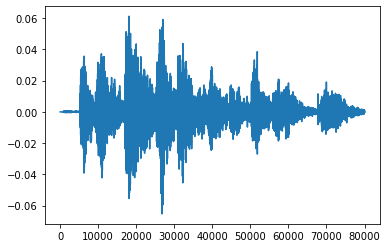

In [46]:
rir_interf = io.loadmat(path_RIR_interf)["impulse_response"][:,:4]
interf,_ = rs.load(path_interf,sr=16000,mono=False)

v = []
for i in range(4) :
    v.append(scipy.signal.fftconvolve(interf,rir_interf[:,i]))
v = np.stack(v)

if v.shape[1] < len_data : 
    v = np.pad(v,(0,len_data-v.shape[1]))
else :
    v = v[:,:len_data]

interf = v[0]
# SIR

interf_rms = (interf ** 2).mean() ** 0.5
snr_scalar = interf_rms / (10 ** (SIR / 20)) / (interf_rms + 1e-13)
v *= snr_scalar


s = r + v
ipd.display(ipd.Markdown('## interf'))
ipd.display(ipd.Audio(v[0], rate=16000))
ipd.display(ipd.Markdown('## x'))
ipd.display(ipd.Audio(x, rate=16000))

plt.figure()
plt.plot(v[0])

noise

angle : 0
angle : 1
angle : 2
angle : 3
angle : 4
angle : 5
angle : 6
angle : 7
angle : 8
angle : 9
angle : 10
angle : 11
angle : 12


## noise

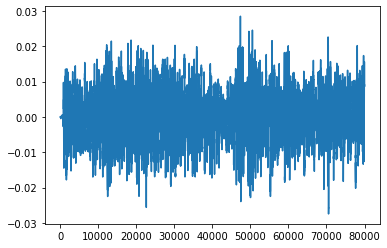

In [47]:
noise = rs.load(path_noise,sr=16000)[0]

# sample noise
noise = noise[:len_data]

list_cur_RIR = list_rir_test[2][:13]
# for all directions

d = None
for i in range(len(list_cur_RIR)) :
    print("angle : {}".format(i))
    n = []
    rir_noise = io.loadmat(list_cur_RIR[i])["impulse_response"][:,:4]
    for j in range(4) : 
        n.append(scipy.signal.fftconvolve(noise,rir_noise[:,j]))
    n = np.stack(n)
    
    if n.shape[1] < len_data : 
        n = np.pad(n,(0,len_data-n.shape[1]))
    else :
        n = n[:,:len_data]
    
    if d is None : 
        d = n
    else :
        d += n
noise = d[0]
noise_rms = (noise ** 2).mean() ** 0.5
snr_scalar = noise_rms / (10 ** (SNR / 20)) / (noise_rms + 1e-13)
d *= snr_scalar

ipd.display(ipd.Markdown('## noise'))
ipd.display(ipd.Audio(d[0], rate=16000))

plt.figure()
plt.plot(d[0])

Mix

## noisy

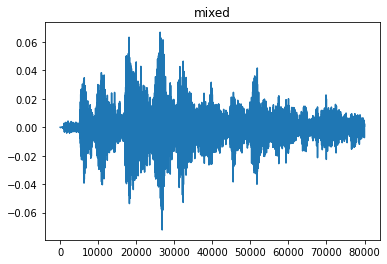

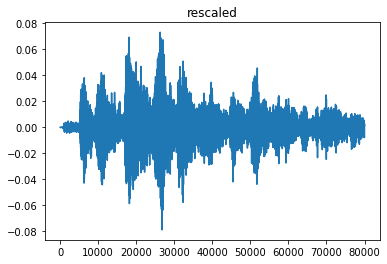

In [55]:
x = s + n
plt.figure()
plt.title("mixed")
plt.plot(x[0])


# dB Management
# resacle noisy RMS
rms = np.sqrt(np.mean(x ** 2))
scalar = 10 ** (-40 / 20) / (rms + 1e-13)
xx = x * scalar

ipd.display(ipd.Markdown('## noisy'))
ipd.display(ipd.Audio(xx[0], rate=16000))

plt.figure()
plt.title("rescaled")
plt.plot(xx[0])

dB

## Check Dataset

In [2]:
root = "/home/data2/kbh/MIDR___Multi-Channel_Impulse_Response_Database/Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_3-3-3-8-3-3-3/"
target = "Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_3-3-3-8-3-3-3_1m_000.mat"

path = os.path.join(root,target)

In [5]:
rir = io.loadmat(path)
print(rir.keys())

dict_keys(['__header__', '__version__', '__globals__', 'simpar', 'metapar', 'impulse_response'])


In [7]:
rir["metapar"]

array([[(array(['Reverberation_0.160s'], dtype='<U20'), array([[0]], dtype=uint8), array([[1]], dtype=uint8), array(['PerfectSweep'], dtype='<U12'), array([[(array(['RME Hammerfall DSP Digiface + ADI-8 DS'], dtype='<U38'), array(['RME Octamic'], dtype='<U11'), array(['Fostex 6301B and ADAM A3X'], dtype='<U25'), array(['8x AKG CK32'], dtype='<U11'))]],
              dtype=[('soundcard', 'O'), ('micpreamp', 'O'), ('loudspeaker', 'O'), ('microphones', 'O')]), array(['Bar-Ilan_University'], dtype='<U19'), array([[0.78190921, 0.87078178, 0.79240494, 0.80242944, 0.74739788,
                0.97152344, 1.        , 0.96765336]]), array(['mic1@90deg, mic8@270deg'], dtype='<U23'), array([[3, 3, 3, 8, 3, 3, 3]], dtype=uint8), array(['covr'], dtype='<U4'), array([[0.16]]), array(['Acoustic_Lab_Bar-Ilan_University'], dtype='<U32'), array(['impulse_response'], dtype='<U16'))                                                       ]],
      dtype=[('array_position', 'O'), ('azimuth', 'O'), ('distance',

In [10]:
rir["impulse_response"].shape

(480000, 8)

Text(0.5, 1.0, 'x')

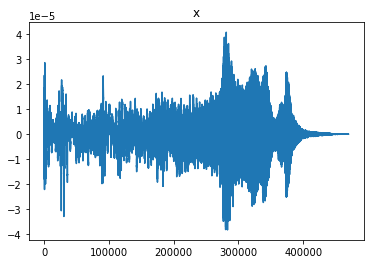

In [16]:
plt.figure()
plt.plot(rir["impulse_response"][10000:,0])
plt.title("x")

In [ ]:
import glob,os
import librosa
import numpy as np



# force re-import
%load_ext autoreload
%autoreload 2


ipd.display(ipd.Markdown('## input'))
ipd.display(ipd.Audio(x, rate=sr))

plt.figure()
plt.plot(x)
plt.title("x")